In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "kaggle"

!mkdir kaggle #create the .kaggle folder in your root directory

!echo '{"username":"thorirhrafn","key":"66bddf37f9b12480c4422871e08090ab"}' > kaggle/kaggle.json #write kaggle API credentials to kaggle.json

!chmod 600 kaggle/kaggle.json  # set permissions

# Get data from Kaggle profile

! kaggle datasets download thorirhrafn/mfcc-images

# Unzip Kaggle data

! unzip mfcc-images.zip

100% 61.9M/61.9M [00:02<00:00, 42.8MB/s]
100% 61.9M/61.9M [00:02<00:00, 30.6MB/s]
Archive:  mfcc-images.zip
  inflating: mfcc/mfcc/blues/00000.png  
  inflating: mfcc/mfcc/blues/00001.png  
  inflating: mfcc/mfcc/blues/00002.png  
  inflating: mfcc/mfcc/blues/00003.png  
  inflating: mfcc/mfcc/blues/00004.png  
  inflating: mfcc/mfcc/blues/00005.png  
  inflating: mfcc/mfcc/blues/00006.png  
  inflating: mfcc/mfcc/blues/00007.png  
  inflating: mfcc/mfcc/blues/00008.png  
  inflating: mfcc/mfcc/blues/00009.png  
  inflating: mfcc/mfcc/blues/00010.png  
  inflating: mfcc/mfcc/blues/00011.png  
  inflating: mfcc/mfcc/blues/00012.png  
  inflating: mfcc/mfcc/blues/00013.png  
  inflating: mfcc/mfcc/blues/00014.png  
  inflating: mfcc/mfcc/blues/00015.png  
  inflating: mfcc/mfcc/blues/00016.png  
  inflating: mfcc/mfcc/blues/00017.png  
  inflating: mfcc/mfcc/blues/00018.png  
  inflating: mfcc/mfcc/blues/00019.png  
  inflating: mfcc/mfcc/blues/00020.png  
  inflating: mfcc/mfcc/blues/00

In [2]:
# Import libraries

import os
import csv
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import pandas as pd
import torch.utils.data
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils

from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

In [3]:
# device will be 'cuda' if a GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
print(torch.cuda.device_count())

1


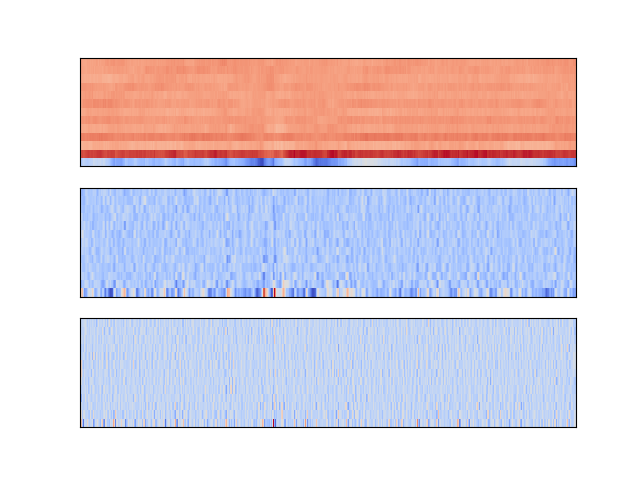

In [5]:
#Check an images

from IPython.display import Image

Image(filename='mfcc_delta/mfcc_delta/classical/00006.png') 

label: 3


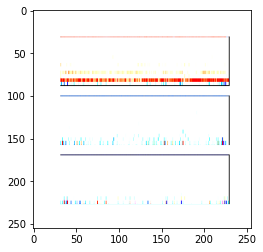

In [6]:
#Create datasets with normalized and scaled images

img_transform = transforms.Compose([
                  transforms.ToTensor(),                     
                  transforms.Resize([255,255]),
                  transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                       std=[0.229, 0.224, 0.225]) #ImgNet dataset mean & std deviation
                  ])   


core_dataset = datasets.ImageFolder(root='mfcc_delta/mfcc_delta', transform=img_transform)

train_len = int(0.8*len(core_dataset))
test_len = len(core_dataset) - train_len
training_dataset, test_dataset = random_split(core_dataset, [train_len, test_len])
val_len = int(0.1*train_len)
training_dataset, validation_dataset = random_split(training_dataset, [train_len-val_len, val_len])

tensor_img = training_dataset[400][0]
print(f'label: {training_dataset[400][1]}')
tensor_img = tensor_img.cpu()
plt.imshow(  tensor_img.permute(1, 2, 0)  )


In [7]:
# create dataloaders for training and testing
SIZE = 32

train_dl = torch.utils.data.DataLoader(training_dataset, batch_size=SIZE, shuffle=True)
val_dl = torch.utils.data.DataLoader(validation_dataset, batch_size=SIZE, shuffle=False)
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=SIZE, shuffle=False)


In [14]:
from torchsummary import summary
# Create Convolutional Neural Network Model (CNN)
class Music_CNN(nn.Module):
  
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Sequential(
        # 3 x 255 x 255
        nn.Conv2d(3, 32, kernel_size=(7,7), stride=2, padding=1),  
        nn.BatchNorm2d(32),
        nn.ReLU(),  
        nn.Conv2d(32,64, kernel_size=(5,5), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=(3,3), stride=1, padding=1), 
        nn.BatchNorm2d(128), 
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )   

    self.conv3 = nn.Sequential(
        nn.Conv2d(128, 256, kernel_size=(3,3), stride=1, padding=1), 
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Conv2d(256,256, kernel_size=(3,3), stride=1, padding=1), 
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.dense = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.5),
        nn.Linear(57600, 128),
        nn.BatchNorm1d(128) ,
        nn.ReLU()
    )
    
    self.out = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(128,10)
    )
    
    return


  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.dense(x)
    x = self.out(x)

    return nn.functional.log_softmax(x, dim=1)   

model = Music_CNN()
model = model.to(device)
print(model)
summary(model,(3,255,255))

Music_CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256,

training loss: 1.2409093379974365
training acc: 0.394
validation loss: 2.0483243465423584
validation acc: 0.367
----------
training loss: 1.1908541917800903
training acc: 0.633
validation loss: 1.2157211303710938
validation acc: 0.658
----------
training loss: 0.7235767841339111
training acc: 0.771
validation loss: 0.9726114273071289
validation acc: 0.785
----------
training loss: 0.7245065569877625
training acc: 0.8
validation loss: 1.0952606201171875
validation acc: 0.759
----------
training loss: 0.5190945863723755
training acc: 0.851
validation loss: 1.5256679058074951
validation acc: 0.582
----------
training loss: 0.7330631613731384
training acc: 0.858
validation loss: 0.7639077305793762
validation acc: 0.797
----------
training loss: 0.4060109257698059
training acc: 0.887
validation loss: 0.7655239105224609
validation acc: 0.823
----------
training loss: 0.8181944489479065
training acc: 0.901
validation loss: 0.6739670634269714
validation acc: 0.81
----------
training loss: 0.48

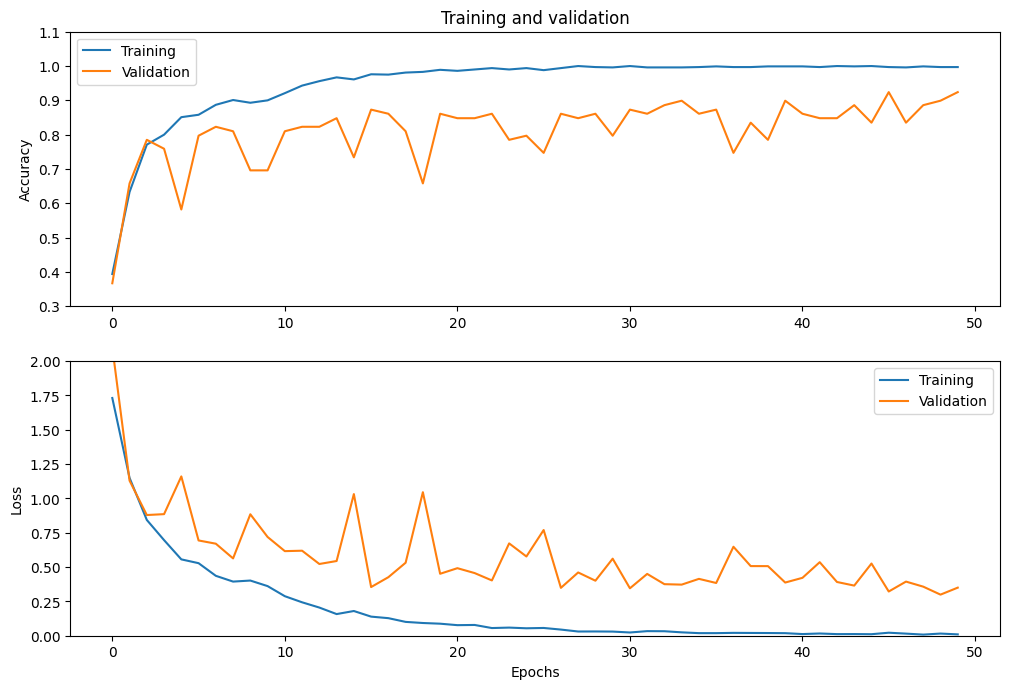

In [15]:
from google.colab import files

# Train my neural network.

t = 0
epochs = []
total_train_loss = []
total_train_acc = []
total_val_loss = []
total_val_acc = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

for epoch in range(50):

  train_correct = 0
  train_total = 0
  train_loss = 0
  val_correct = 0
  val_total = 0
  val_loss = 0
  epochs.append(epoch)

  model.train()

  for data in train_dl:
    X_train, y_train = data
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    optimizer.zero_grad() # clear gradient information.
    output_train = model(X_train)

    for index, value in enumerate(output_train):
      if torch.argmax(value) == y_train[index]:
        train_correct += 1
      train_total += 1

    # print(f'output: \n {output}')
    # print(f'label: {y_train}')
    loss = nn.functional.nll_loss(output_train, y_train)
    loss.backward() # do pack-propagation step
    optimizer.step() # tell optimizer that you finished batch/iteration.
    train_loss += loss.item()
  # save loss and accuracy for this epoch
  total_train_loss.append(train_loss/len(train_dl))
  total_train_acc.append(round(train_correct/train_total, 3))
  print(f'training loss: {loss.data}')
  print(f'training acc: {round(train_correct/train_total, 3)}')
  

  model.eval()
  with torch.no_grad(): 
    for val_data in val_dl:
      X_val, y_val = val_data
      X_val = X_val.to(device)
      y_val = y_val.to(device)
      output_val = model(X_val)

      for index, value in enumerate(output_val):
        if torch.argmax(value) == y_val[index]:
          val_correct += 1
        val_total += 1

      loss = nn.functional.nll_loss(output_val, y_val)  # loss/cost/error function
      val_loss += loss.item()
    # save loss and accuracy for this epoch  
    total_val_loss.append(val_loss/len(val_dl))  
    total_val_acc.append(round(val_correct/val_total, 3))
    print(f'validation loss: {loss.data}')
    print(f'validation acc: {round(val_correct/val_total, 3)}')
    print("----------")

plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(2,1,1)
plt.plot(epochs, total_train_acc, label="Training Accuracy")
plt.plot(epochs, total_val_acc, label="Validation Accuracy")
plt.title("Training and validation")
plt.ylabel('Accuracy')
plt.ylim(0.3,1.1)
plt.legend(["Training", "Validation"])

plt.subplot(2,1,2)
plt.plot(epochs, total_train_loss, label="Training Loss")
plt.plot(epochs, total_val_loss, label="Validation Loss")
plt.ylabel('Loss')
plt.ylim(0,2)
plt.xlabel('Epochs')
plt.legend(["Training", "Validation"])

plt.show()    


Accuracy: 90.5
----------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        24
           1       1.00      1.00      1.00        27
           2       1.00      0.95      0.98        22
           3       0.94      0.85      0.89        20
           4       0.76      1.00      0.86        16
           5       0.94      0.81      0.87        21
           6       0.86      0.95      0.90        20
           7       0.84      0.89      0.86        18
           8       0.87      0.72      0.79        18
           9       0.73      0.79      0.76        14

    accuracy                           0.91       200
   macro avg       0.90      0.90      0.89       200
weighted avg       0.91      0.91      0.90       200



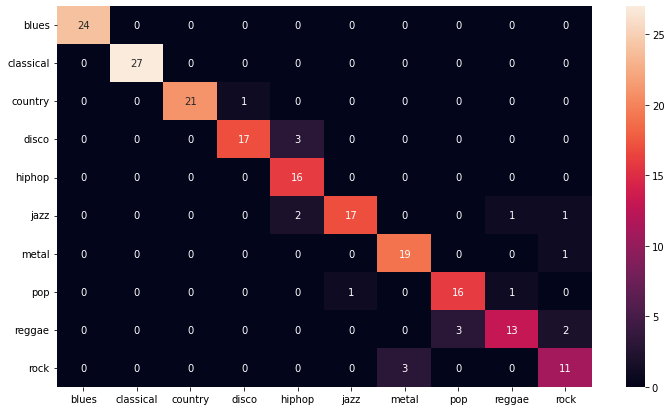

In [16]:
from sklearn.metrics import classification_report

# Evaluate the trained network.

total = 0
correct = 0
y_pred = []
y_target = []

with torch.no_grad():   # No need for keepnig track of necessary changes to the gradient.
  for data in test_dl:
    X, y = data
    X = X.to(device)
    y = y.to(device)
    output = model(X)

    for index, value in enumerate(output):
        pred = torch.argmax(value).squeeze(0).cpu()
        target = y[index].squeeze(0).cpu()
        # print(f'Predicion: {pred} , Target: {target}')
        y_pred.append(pred)
        y_target.append(target) 
        if pred == target:
          correct += 1
        total += 1 

    accuracy = 100*correct/total   

  print('Accuracy:', accuracy)     
  print("----------")

classes = ('blues', 'classical','country','disco','hiphop','jazz','metal','pop','reggae','rock')

# Build confusion matrix
cf_matrix = confusion_matrix(y_target, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)  

print(classification_report(y_target, y_pred))